# 3D volume rendering of geophysical data using the yt platform

**Authors**: Christopher Havlin<sup>1,2</sup>,  Benjamin Holtzman<sup>1</sup>, Kacper Kowalik<sup>2</sup>, Madicken Munk<sup>2</sup>, Sam Walkow<sup>2</sup>, Matthew Turk<sup>2</sup> 

1. Lamont-Doherty Earth Observatory, Columbia University 
2. University of Illinois Urbana-Champagne 

## 1. Abstract 

We present novel applications of *yt*, a tool originally designed for analysis of astrophysics datasets, to the geosciences. *yt* (http://yt-project.org) is a python-based platform for volumetric data, which enables semantically meaningful analysis and visualization. As part of a wider effort to bring *yt* to the geosciences, we present an initial use-case of *yt* applied to 3D seismic tomography models of the upper mantle from the IRIS Earth Model Collaboration. While the rendering capabilities of yt can in general be applied directly to 3D geoscience data, we add several graphical elements to the 3D rendering to aid in interpretation of volume renderings including latitude/longitude overlays and shapefile support for plotting political and tectonic boundaries along the Earth’s surface. In this notebook, we focus on tomographic models of North America and the Western U.S., where high resolution models and rapidly varying seismic properties provide a rich dataset to explore systematically at a range of lengthscales. The notebook demonstrates loading and rendering of IRIS netcdf models, highlighting interesting 3D features of the Western U.S. upper mantle, and goes on to demonstrate how having direct control of the transfer functions used in creating the final volume rendering allows for a more systematic exploration of the role of the visualization method in our interpretation of 3D volumetric data. Finally, we conclude by demonstrating some of the semantically-aware capabilities of *yt* for analysis purposes, and demonstrate how these tools have cross-disciplinary functionality.

## 2. Background

An increasing number of efforts have focused on expanding the geoscience domains in which *yt* is used, including weather simulations, observational astronomy, oceanography and hydrology. Within the realm of upper mantle geophysics, *yt* has been used to visualize seismic wavefronts from forward modeling (Holtzman et al. 2014) and in this work we demonstrate an initial use-case of *yt* in visualizing upper mantle geophysical data. Geophysical data contains rich 3D structure that maps the material properties of the upper mantle, including elastic properties (shear wave and compressional wave velocities, attenuation) and electrical properties (conductivity or resistivity). While 3D structure is inherent to all geophysical datasets, 3D visualization is not commonly used by seismologists and most studies interpret 2D slices through the 3D data. In the occasional studies where 3D visualization is used, authors rely on 3D isosurfaces (e.g., Obreski et al. 2010) and while isosurfaces can reveal 3D structure, the noisy nature of the data results in significantly different emergent structure depending on small deviations in the chosen value for an isosurface. In contrast to rendering isosurfaces, volume rendering allows spatially variable transparency, such that the noise is de-emphasized and the most robust anomalies dominate the image. The physical interpretation of 3D tomographic images should become less dependent on arbitrary choices in the visualization scheme. Volume rendering can be an important tool towards that aim.

In this notebook, we focus on a single tomographic model **NWUS11-S**, which maps shear wave velocity anomalies, $dV_s$, in the northwest United States (James et al., 2011). Shear wave velocity in the Earth depends on composition and thermodynamic state (e.g., temperature, melt fraction) and to first order, maps of velocity anomalies highlight regions of the mantle that are hotter (slower) or cooler (faster) than expected relative to a 1D reference model. These thermal anomalies result in density and effective viscosity variations that drive mantle convection and plate tectonics, so maps of velocity anomalies provide important insight into many questions in geophysics. The upper mantle beneath the northwest U.S. is an ideal region for 3D visualization because it contains a wide range of regional tectonic processes including subduction of the Pacific plate beneath the Cascades and voluminous volcanic activity for the past ~50 Myrs including the Yellowstone Hot Spot (e.g. Humphreys 1995). And **NWUS11-S** is an ideal tomographic model to visualize in 3D with *yt* because of its relatively high spatial resolution thanks to leveraging of the Earthscope‐USArray seismic network. Furthermore, because **NWUS11-S** is one of the models included in the Incorporated Research Institutions for Seismology (IRIS) Earth Model Collaboration (EMC) using the standardized netCDF format for 3-D models (citation), the code developed in the present repository is reasonably general and other models can be easily loaded.

## 3. Overview of Notebook

The following image shows an example of volume rendering of data from **NWUS11-S** in which slow and fast anomalies are mapped to warm and cool colors, respectively. Annotations along the Earth's surface include tectonic boundary lines (blue: divergent boundaries, red: convergent boundaries and pink: transform boundaries) and eruptions of the past 10,000 years (green circles). 

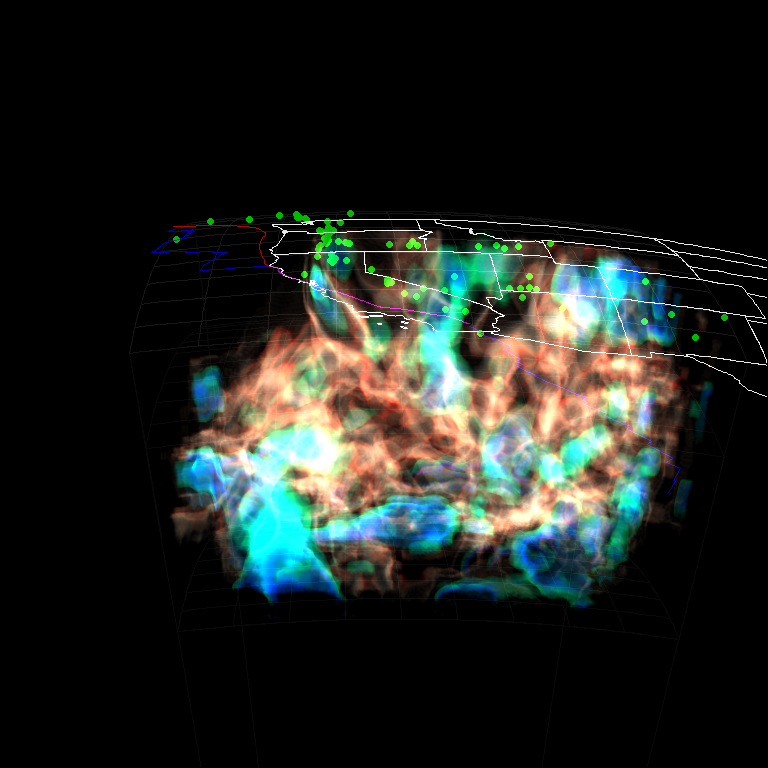

In [1]:
import os
from IPython.display import Image 
Image(filename = os.path.join('resources','InitVolume.png'))

The blue regions near the surface in the Pacific Northwest correspond to the cold, subducting Cascadian plate which drives volcanism within the Cascades. Farther east, James et al. (2011) interpret the fast anomalies beneath Idaho and Utah/Wyoming as remnant slabs from when the entirety of the tectonic border along the western U.S. was an active subduction zone. The "gap" between these two fast anomalies is the present day location of Yellowstone (the green dot on the Idaho/Wyoming border). James et al. (2011) hypothesize that the formation and migration of the Yellowstone hot spot is due to changes in subduction dynamics: the fragmentation and foundering of the slabs drove hot material through the slab gap. The anomalies deeper in the model domain are more enigmatic and the most salient feature is simply the prevalence of slow (hot) mantle beneath the western U.S., consistent with the ongoing volcanism of the past 50 Myrs (e.g., Humphreys 1995).

The above image contains detail that is difficult to achieve with 3D isosurfaces and in the remainder of the notebook, we describe the different components required for generating volume renderings from IRIS EMC files: in sections 4 and 5 demonstrate how to load uniformly gridded geophysical data sets into *yt* and how to set transfer functions for volume rendering to highlight ranges of data, respectively. Section 6  demonstrates how to adjust the orientation of the 3D view to aid interpretation. Together, these sections demonstrate the typical workflow for loading and rendering with *yt*:

1. initialize the *yt* scene: load data volume source and add annotation volume sources
2. set the viewing angle with a camera object
3. set the transfer function (how the data is rendered).     
4. render the image

To modify this notebook, whether running a local jupyter server or running the binder-docker image, first run all cells to ensure the required packages are loaded and functions defined.


## 4. Loading IRIS Earth Model Collaboration (EMC) Files

The IRIS EMC (Trabant et al., 2012, http://ds.iris.edu/ds/products/emc-earthmodels/) is a rich database of geophysical models that serves as an excellent testing ground for using *yt* with geophysical data. As the 3D EMC models are standardized netCDF files, different models can be easily interchanged.

At present, the initialization workflow for loading 3D IRIS EMC models with *yt* consists of (4.1) loading required packages, (4.2) interpolation and (4.3) annotation. 

### 4.1 Loading packages
 
We begin by importing the libraries and setting required environment variables. In addition to the standard `yt` package, the present notebook relies on a supplementary `yt_velmodel_vis` package ([link](https://github.com/chrishavlin/yt_velmodel_vis)) that facilitates data loading and transformations for seismic data as described below. Note that the present repository for the 2020 EarthCube Annual Meeting notebook (https://github.com/earthcube2020/ec20_havlin_etal) includes a copy of the package so that future changes to the package will not break the present notebook. 

In [2]:
# imports and initialization
import os,yt, numpy as np
import matplotlib.pyplot as plt
from yt_velmodel_vis import seis_model as SM,shapeplotter as SP, transferfunctions as TFs

os.environ['YTVELMODELDIR']='./data' # local repo path to data directory 
for axtype in ['axes','xtick','ytick']:
    plt.rc(axtype, labelsize=14)

The `yt_velmodel_vis` package uses a simple filesystem database in which raw model files, interpolated model files and shapefiles for annotation are stored in the directory set by the `YTVELMODELDIR` environment variable. For normal usage outside this notebook, after installing `yt_velmodel_vis`, a user can set this environment variable to any directory and run the following from a Python interpreter to initialize the database:

```
from yt_velmodel_vis import datamanager as dm
dm.initializeDB()
```

This will setup the local filesystem database, building the expected file tree structure and fetching some initial data including IRIS models and useful shapefiles. Once files stored within the filesystem database, the user needs to only supply the filename, not the complete path (as long as file names are unique). In the case of the shapefiles, there are also short-names for easier access. If loading a file outside the database, the filenames must be full paths. In the above cell, we set the data directory relative to the location of the present notebook within the github repository, which already contains the data required for the notebook.

### 4.2 Interpolation 
At present, 3D volume rendering in *yt* is restricted to cartesian coordinates, but IRIS EMC files are in geo-spherical coordinates (i.e., latitude, longitude and depth). A working implementation of spherical volume rendering exists (Kellison and Gyurgyik, in prep), but for the current demonstration we must first interpolate from spherical to cartesian coordinates. The `yt_velmodel_vis.seis_model` class contains a KDTree-Inverse Distance Weighting algorithm to populate values on the cartesian grid by finding the nearest N model data and weighting the values by distance from the point on the new cartesian grid.

While the resolution of the cartesian grid, number of nearest neighbors and max distance allowed in the nearest neighbor search are all adjustable parameters, the interpolation from spherical to cartesian coordinates is computationally demanding and so the current notebook loads a pre-built interpolation included in the repository's notebook data directory (`notebooks/data/`) for **NWUS11-S**, defined by the interpolation dictionary (`interp_dict`) in the following code cell.

In [3]:
# load interpolated data using the yt uniform grid loader (not editable)

# set the model file and the field to visualize
modelfile='NWUS11-S_percent.nc' # the model netCDF file 
datafld='dvs' # the field to visualize, must be a variable in the netCDF file

# set the interpolation dictionary. If the interpolation for this model does 
# not exist, SM.netcdf() will build it. 
interp_dict={'field':datafld,'max_dist':50000,'res':[10000,10000,10000],
              'input_units':'m','interpChunk':int(1e7)}

# load the model 
model=SM.netcdf(modelfile,interp_dict)

# set some objects required for loading in yt 
bbox = model.cart['bbox'] # the bounding box of interpolated cartesian grid
data={datafld:model.interp['data'][datafld]} # data container for yt scene

# load the data as a uniform grid, create the 3d scene
ds = yt.load_uniform_grid(data,data[datafld].shape,1.0,bbox=bbox,nprocs=1,
                        periodicity=(True,True,True),unit_system="mks")

print("Data loaded.")

yt : [INFO     ] 2020-09-09 10:24:18,525 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-09-09 10:24:18,526 Parameters: domain_dimensions         = [287 271 237]
yt : [INFO     ] 2020-09-09 10:24:18,526 Parameters: domain_left_edge          = [-5201282.   -3445670.25  2740212.5 ]
yt : [INFO     ] 2020-09-09 10:24:18,527 Parameters: domain_right_edge         = [-2328344.5     -735306.5625  5113796.5   ]
yt : [INFO     ] 2020-09-09 10:24:18,527 Parameters: cosmological_simulation   = 0.0


Data loaded.


It is worth noting that any netCDF file with uniformly spaced data could be loaded using the `yt.load_uniform_grid` loader. In the present application, the `SM.netcdf()` simply wraps the generic python netCDF4 in order to add methods that are useful for seismic tomography model. But, the `data` dictionary can contain any 3D numpy array. 

### 4.3 Loading IRIS EMC Files: Building the scene 

The `yt.scene` object contains the information on how and what to render. In addition to specifying which field of the data to render, we can add annotations. While *yt* has methods for adding annotations to a volume rendering, because we want to add annotations reflecting the original spherical domain, we use routines in the `yt_velmodel_vis` package to manually add annotations as line and point sources.

Additionally, as opposed to the astrophysical datasets that *yt* was originally designed for, interpretation of geophysical datasets typically requires correlation along one boundary of the 3D data (the Earth's surface). The surficial expression of plate tectonics is directly related to the material properties of the underlying mantle, and so any 3D visualization of geophysical data requires some level of mapping to the regional tectonics at the Earth's surface. And so the `yt_velmodel_vis.shapeplotter` module contains routines to facilitate plotting shapes at the Earth's surface in the 3D view including latitude and longitude grids and automated parsing and transformation of shapefiles. The `shapeplotter` module leverages the `geopandas` library for automating the reading of shapefiles and includes transformations from geo-spherical coordinates to geocentric cartesian coordinates. 

In the present visualizations, we include tectonic boundaries (Coffin et al., 1998), sites of volcanism of the last 10,000 years (Simkin and Siebert, 1994) and US political boundaries (Natural Earth, https://www.naturalearthdata.com/). 

In [4]:
def build_yt_scene():
    """ builds the yt scene: 
    
    - Draws the spherical chunk bounding the dataset 
    - Draws a latitude/longitude grid at surface
    - Draws shapefile data: US political boundaries, tectonic boundaries, volcanos 
    
    """
    
    # create the scene (loads full dataset into the scene for rendering)
    sc = yt.create_scene(ds,datafld)    
    
    # add useful annotations to the scene in two parts: 1. Domain Annotations and 2. Shapefile Data
            
    # 1. Domain Annotations :    
    # define the extent of the spherical chunk 
    lat_rnge=[np.min(model.data.variables['latitude']),np.max(model.data.variables['latitude'])]
    lon_rnge=[np.min(model.data.variables['longitude']),np.max(model.data.variables['longitude'])]    
    Depth_Range=[0,1200]    
    R=6371.
    r_rnge=[(R-Depth_Range[1])*1000.,(R-Depth_Range[0])*1000.]
    
    # create a spherical chunk object 
    Chunk=SP.sphericalChunk(lat_rnge,lon_rnge,r_rnge) 
    
    # add on desired annotations to the chunk
    sc=Chunk.domainExtent(sc,RGBa=[1.,1.,1.,0.002],n_latlon=100,n_rad=50) # extent of the domain
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.005]) # lat/lon grid at the surface
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-410.)*1000.) # lat/lon grid at 410 km depth
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-Depth_Range[1])*1000.) #lat/lon grid at lower extent
    sc=Chunk.wholeSphereReference(sc,RGBa=[1.,1.,1.,0.002]) # adds lines from Earth's center to surface 

    # 2. Shapefile Data    
    # set the surficial bounding box, used for reading all shapefiles
    shp_bbox=[lon_rnge[0],lat_rnge[0],lon_rnge[1],lat_rnge[1]] 

    # US political boundaries 
    thisshp=SP.shapedata('us_states',bbox=shp_bbox,radius=R*1000.)
    sc=thisshp.addToScene(sc)

    # tectonic boundaries: buid a dictionary with unique RGBa values for each
    clrs={
        'transform':[0.8,0.,0.8,0.05],
        'ridge':[0.,0.,0.8,0.05],
        'trench':[0.8,0.,0.,0.05],
        'global_volcanos':[0.,0.8,0.,0.05]
    }
    for bound in ['transform','ridge','trench','global_volcanos']:
        tect=SP.shapedata(bound,radius=R*1000.,buildTraces=False)
        sc=tect.buildTraces(RGBa=clrs[bound],sc=sc,bbox=shp_bbox)
        
    return sc   

In the preceding code, two types of annotations are added: domain and shapefile annotations. 

While *yt* includes methods for annotating meshes and grids of volume renderings, those methods act on the interpolated cartesian grid supplied in the initial call to `yt.load_uniform_grid()`. For example, a call to `sc.annotate_domain()` will add the 3D boundaries of the volume being rendered. But it is more insightful to plot the boundaries of the original spherical dataset, and so the `SP.sphericalChunk()` class includes methods to facilitate annotating the original domain extent in spherical coordinates. Once spherical volume rendering is fully implemented in *yt*, domain annotation will be more straightforward. 

For shapefile data, the data from each shapefile is added in two steps:

1. Loading and parsing the shapefile, `SP.shapedata()`
2. Adding the shapefile traces to the *yt* scene `SP.shapedata.addToScene()` or `SP.shapedata.buildTraces()`

When loading the shapefile, the `radius` argument specifies what radius to draw the shapes at (in the above cases, drawing tectonic boundaries at the Earth's surface). The traces are added as a `LineSource` or `PointSource` from the *yt* volume rendering package, `yt.visualization.volume_rendering.api`. If using default colors, the traces are built on initial data load and then added to the scene object (`sc`) with `SP.shapedata.addToScene(sc)`. The user can also specify the RGBa to use in drawing each shapefile, in which case, `SP.shapedata()` is called with the `buildTraces` argument set to `False` and the traces are added to the scene object as soon as they are built by setting the `sc` argument in the call to `SP.shapedata.buildTraces()`.

Because the shapefiles being plotted are included in the `yt_velmodel_vis` package, they are referred to using their *shortnames* (`'us_states'`, `'transform'`, etc.) rather than full filename. To parse a shapefile that is not included, the user can supply the full path as the first argument rather than the *shortname*. 

The final settings required before discussing the volume rendering are the properties controlling camera position and viewing angle. The *yt* documentation provides an overview of camera positioning and related settings ([yt Volume Rendering Overview](https://yt-project.org/doc/visualizing/volume_rendering.html#volume-rendering)), and so for the present notebook, we simply create a function that adjusts the scene object for the present dataset to provide a reasonable initial viewing angle:

In [5]:
def getCenterVec():
    # center vector
    x_c=np.mean(bbox[0])
    y_c=np.mean(bbox[1])
    z_c=np.mean(bbox[2])
    center_vec=np.array([x_c,y_c,z_c])
    return center_vec / np.linalg.norm(center_vec)
    
def setCamera(sc):
    pos=sc.camera.position
    
    # center vector
    center_vec=getCenterVec()
    sc.camera.set_position(pos,north_vector=center_vec)

    # zoom in a bit 
    zoom_factor=0.7 # < 1 zooms in
    init_width=sc.camera.width
    sc.camera.width = (init_width * zoom_factor)
    

## 5 Transfer Functions

3D volume rendering in `yt` uses ray-tracing through the 3D volume: rays are passed through the volume sources within a scene to the camera and the final RGB value of each pixel in the image is an integration of the RGBa values along each raypath. The **transfer function** maps the value of the data field at each voxel to an RGBa value, determining how much an individual voxel contributes to the final composite.

The following image contains an example of a transfer function (left) and volume rendering (right): 

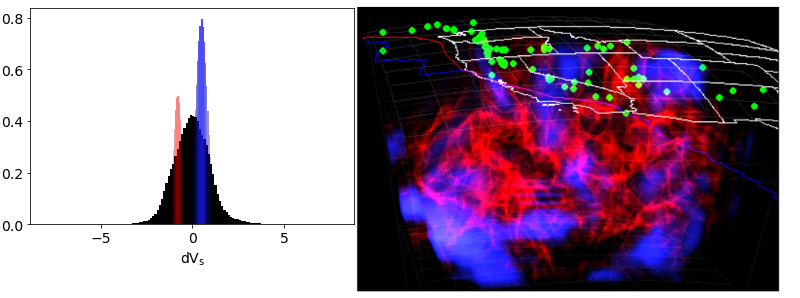

In [6]:
from IPython.display import Image 
Image(filename = os.path.join('resources','TFexample.png'))

The transfer function plot (left) contains a normalized histogram of the velocity anomaly, $dV_s$, over the whole domain, in black. The red and blue Guassian distributions represent the transfer function: the y-axis corresponds to the transmission coefficient (0 for transparent, 1 for opaque) and the $dV_s$ values falling within each respective Gaussian are assigned the corresponding RGB value. The given transfer function results in the volume rendering to the right. The blues correspond to the range of positive velocity anomalies bounded by the blue Gaussian in the transfer function plot, while the reds correspond to the slow velocity anomalies bounded by the red Gaussian. 

By modifying the functional form of the transform functions, different ranges of the data can be easily sampled. Furthermore, colormaps can be applied to data ranges to provide even more detail. In the following sections, we demonstrate how to create the above figure, and then how to modify the transfer function in more complex ways.

### 5.1 Transfer Functions: yt presets

*yt* provides a variety of preset transfer functions, but first, we define a simple function to pull out the values from a given transfer function to plot on top of a histogram of the data:

In [7]:
def plotTf_yt(tf,dvs_min,dvs_max):     
    x = np.linspace(dvs_min,dvs_max,tf.nbins) # RGBa value defined for each dvs bin in range
    y = tf.funcs[3].y # the alpha value of transfer function at each x 
    w = np.append(x[1:]-x[:-1], x[-1]-x[-2]) 
    colors = np.array([tf.funcs[0].y, tf.funcs[1].y, tf.funcs[2].y,
                       tf.funcs[3].y]).T
    fig = plt.figure()
    ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])
    d_hist=ax.hist(data['dvs'][~np.isnan(data['dvs'])].ravel(),bins=100,density=True,log=False,color='k')
    ax.bar(x, tf.funcs[3].y, w, edgecolor=[0.0, 0.0, 0.0, 0.0],
           log=False, color=colors, bottom=[0])
    plt.xlabel('$\mathregular{dV_s}$')    
    plt.show()

One of the simplest *yt* transfer function methods is to add a Gaussian to highlight a narrow range of the data. The user initializes a transfer function, and then adds a Gaussian described by the center of the peak, the peak width and the RGBa value of the center point:

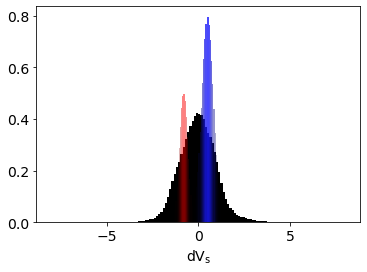

In [8]:
# initialize the tf object by setting the data bounds to consider
dvs_min=-8
dvs_max=8 
tf = yt.ColorTransferFunction((dvs_min,dvs_max))

# set gaussians to add 
TF_gaussians=[
    {'center':-.8,'width':.1,'RGBa':(1.,0.,0.,.5)},
    {'center':.5,'width':.2,'RGBa':(0.1,0.1,1.,.8)}
]

for gau in TF_gaussians:
    tf.add_gaussian(gau['center'],gau['width'],gau['RGBa'])
    
# plot the transfer function     
plotTf_yt(tf,dvs_min,dvs_max)

Once the transfer function is set, the volume rendering can be created. Because we will explore different transfer functions below, we first define a function to build the yt scene object, using functions defined in the previous section.

In [9]:
def configure_scene(the_transfer_function,res_factor=1.):
    # build scene, apply camera settings, set the transfer function 
    sc = build_yt_scene() 
    setCamera(sc)
    source = sc.sources['source_00']
    source.set_transfer_function(the_transfer_function)
    
    # adjust resolution of rendering 
    res=sc.camera.get_resolution()    
    new_res=(int(res[0]*res_factor),int(res[1]*res_factor))
    sc.camera.set_resolution(new_res)
    
    print("Scene ready to render")
    return sc

Given a transfer function, we can then run all the steps required before final rendering with:

In [10]:
sc = configure_scene(tf,res_factor=1.25)

Scene ready to render


The scene is now ready to render, which is done by calling `sc.show()`. Note that the initial rendering may take a few minutes when running the notebook from the Binder image. 

yt : [INFO     ] 2020-09-09 10:24:47,471 Rendering scene (Can take a while).
yt : [INFO     ] 2020-09-09 10:24:47,606 Creating volume
/home/chavlin/miniconda3/envs/yt_vis/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


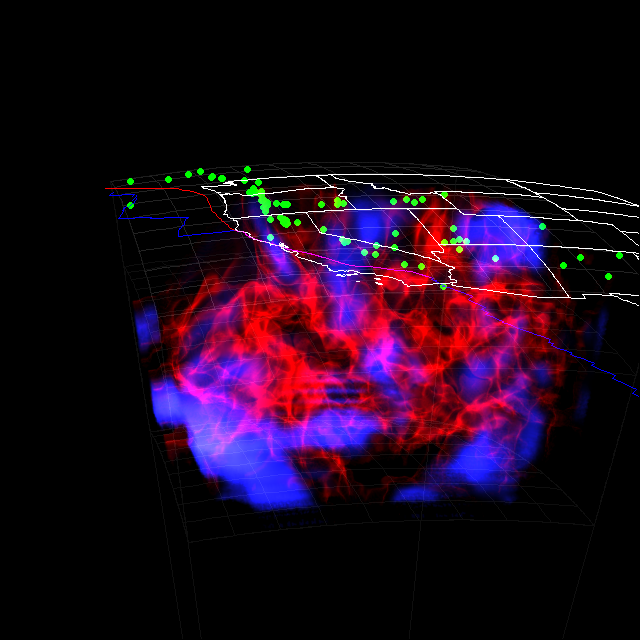

In [11]:
sc.show(sigma_clip=1.5)

The argument `sigma_clip=1.5` controls the contrast of the final image, which is useful for fine tuning the final brightness of the image (e.g., [Sigma Clip](https://yt-project.org/doc/cookbook/complex_plots.html#cookbook-sigma-clip)).  

### 5.2 Transfer Functions: Customization

The transfer function object is a 4D numpy array of RGBa values, and so it is straightforward to create custom transfer functions for a particular application. Here, we demonstrate a more complex transfer function built to clearly differentiate slow and fast anomalies over a wider range of data than the Gaussian example. This example uses transfer function routines from the `yt_velmodel_vis.transfer_functions` module and so we define a new plotting function before building the transfer function:

In [12]:
def plotTf(tfOb):
    """ create a histogram-transfer function plot and display it"""
    f=plt.figure()
    ax=plt.axes()
    ax=tfOb.addHist(ax=ax,density=True,color=(0.,0.,0.,1.))
    ax=tfOb.addTFtoPlot(ax=ax)
    ax.set_xlabel('$\mathregular{dV_s}$')     
    plt.show()

The `yt_velmodel_vis.transfer_functions` module allows different data ranges to use different colormaps to draw out contrast details. Any of the colormaps available in *yt* may be selected (see this [link](https://yt-project.org/doc/visualizing/colormaps/index.html#displaying-colormaps-locally) for how to view available colormaps). 

In this example, we divide the transfer function into two separate segments for slow and fast anomalies and within each segment, the transmission coefficient varies linearly:

$\alpha(dV_s) = \alpha_o - \frac{\Delta{\alpha}}{\Delta{dV_s}}(dV_s-dV_s^o) $

where the $\alpha_o$ and change in $\alpha$ over the segment, $\Delta{\alpha}$ are constants that vary between segments, $\Delta{dV_s}$ is the range of each segment and $dV_s^o$ is the min $dV_s$ value within the segment.

In our implementation below, the transmission coefficient varies inversely with the distribution of observations: having a lower transmission coefficient where there is more data prevents the more prevalent values from overwhelming the image and obscuring structure. 

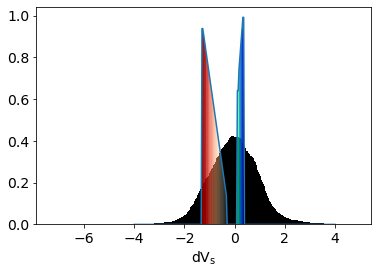

Ready to build scene


In [13]:
# setting up transfer functions 
tfOb = TFs.dv(data[datafld].ravel(),bounds=[-4,4])

# segment 1, slow anomalies
bnds=[-1.3,-.3]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='OrRd_r')
alpha_o=0.95
Dalpha=-0.85
alpha=alpha_o + Dalpha/(bnds[1]-bnds[0]) * (TFseg.dvbins_c-bnds[0])
tfOb.addTFsegment(alpha,TFseg)

# segment 2, fast anomalies
bnds=[.1,.35]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='winter_r')
alpha_o=.6
Dalpha=.4
alpha=alpha_o+ Dalpha/(bnds[1]-bnds[0]) * (TFseg.dvbins_c-bnds[0])
tfOb.addTFsegment(alpha,TFseg)
    
plotTf(tfOb)
print("Ready to build scene")


And once again, we build the scene and render:

In [14]:
# build scene, apply camera settings, set the transfer function 
sc = configure_scene(tfOb.tf,res_factor=1.25)

Scene ready to render


yt : [INFO     ] 2020-09-09 10:25:10,399 Rendering scene (Can take a while).
yt : [INFO     ] 2020-09-09 10:25:10,627 Creating volume


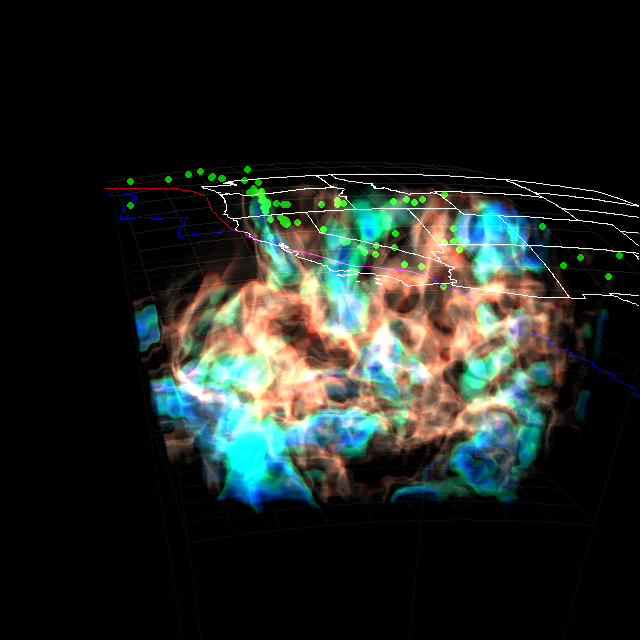

In [15]:
sc.show(sigma_clip=1.5) # render the scene 

While the same features are visible in both volume renderings above, the second one captures more variability, particularly within the fast anomalies. 

### 6. Changing Perspective

To fully grasp the structure visible in 3D renderings, it is necessary to view the volumes from different angles. There are a number of ways to vary 3D orientation in *yt* by modifying the `camera` object in a scene ([link to *yt* documentation](https://yt-project.org/doc/visualizing/volume_rendering.html#moving-and-orienting-the-camera)) and we briefly demonstrate how to change the camera position and how to rotate the camera about a given axis. 

Given that we are working in cartesian coordinates, the simplest way to set a new camera position is to modify the initial position. In the following cell, we first extract the position of the camera, a 3-element array, and then modify the first dimension by a factor (1.1 in this case), which moves the camera to a lower angle view relative to the center of the domain. 

For the rotation, we rotate by -15 degrees around the vector that points through the center of the domain. The resulting perspective is roughly perpendicular to the Cascadian volcanic front and subducting slab.  

yt : [INFO     ] 2020-09-09 10:25:28,232 Rendering scene (Can take a while).


Scene ready to render


yt : [INFO     ] 2020-09-09 10:25:28,552 Creating volume


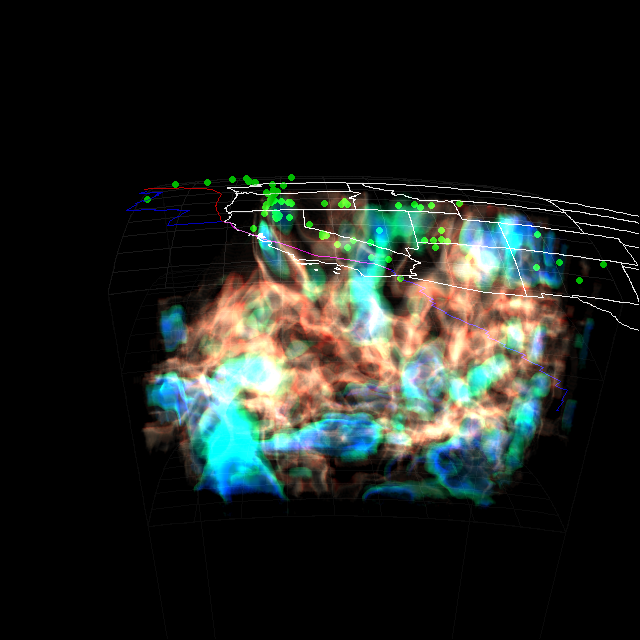

In [16]:
sc = configure_scene(tfOb.tf,res_factor=1.25)

# adjust the camera position to a lower angle view
pos=sc.camera.get_position() # pos is a 3 element array 
pos[0]=pos[0]*1.1 
center_vec=getCenterVec() 
sc.camera.set_position(pos,north_vector=center_vec)

# rotate by -15 degrees 
sc.camera.rotate(-15*np.pi/180., rot_vector=center_vec)
sc.show(sigma_clip=1.5) # render the scene 


By iteratively varying the position and rotation parameters, we can easily produce a serires of frames that can be stitched together into a video. The script [NWUS11S_animation.py](https://github.com/earthcube2020/ec20_havlin_etal/blob/master/scripts/NWUS11S_animation.py) produces a video that lowers this viewing perspective, zooms and rotates the volume. 

The following cell shows the resulting video. Note that the video may not display in static notebook viewers such as nbviewer.jupyter.org, in which case the video may be viewed externally at https://youtu.be/GEvu1PRNDjE or downloaded directly from [here](https://github.com/earthcube2020/ec20_havlin_etal/raw/master/notebook/resources/NWUS11-S-rotation.mp4).

In [17]:
from IPython.core.display import Video
Video(os.path.join('resources','NWUS11-S-rotation.mp4'))

### 7. Future Work

The present notebook demonstrates an initial use-case of *yt* for volume rendering of seismic tomography. We have focused on laying out the technical steps required to produce volume renderings of IRIS Earth Model Collaboration netCDF files, which lays the groundwork for more interpretive work. In future work, we plan to more systematically investigate the  influence of color map choices (e.g., Zeller and Rogers 2020) and transfer functions on our interpretation of geophysical data. 

Additionally, a number of planned developments will simplify the process of using *yt* for tomography renderings and aid in interpreting seismic structure. These developments generally fall into categories of improving functionality of the `yt_velmodel_vis` package and improving the seismological context:

**Improving functionality**

* Further automation of loading IRIS netCDF files, including: 
    * automatic import of all available field variables.
    * automatic calculation of velocity perturbations for a range of 1-D reference models when files include only absolute velocities. 
* Support for loading tomographic models in other formats.
* Direct spherical volume rendering using recent implementation in *yt* (Kellison and Gyurgyik, in prep), removing the need for interpolation to cartesian coordinates. 
* Expanding the *yt* units-awareness to include seismological fields.
* Support for composite model renderings to allow loading of regional studies covering different lengthscales.

**Improving geophysical context**

* overlaying earthquake epicenters.
* overlaying 3d reference ray paths calculated using open source seismological libraries (e.g., ObsPy http://obspy.org).





### References

* Coffin, M.F., Gahagan, L.M., and Lawver, L.A., 1998. "Present-day Plate Boundary Digital Data Compilation." University of Texas Institute for Geophysics Technical Report No. 174, pp. 5., http://www-udc.ig.utexas.edu/external/plates/data.htm
* Holtzman B., Candler J., Turk M., Peter D., 2014. "Seismic Sound Lab: Sights, Sounds and Perception of the Earth as an Acoustic Space." In: Aramaki M., Derrien O., Kronland-Martinet R., Ystad S. (eds) Sound, Music, and Motion. CMMR 2013. Lecture Notes in Computer Science, vol 8905. Springer, Cham.
* IRIS EMC: http://ds.iris.edu/ds/products/emc-earthmodels/
* Humphreys, E. D. 1995. "Post-Laramide removal of the Farallon slab, western United States." Geology, 23(11), 987-990.
* James D.E., M.J. Fouch, R.W. Carlson and J.B. Roth. 2011. “Slab fragmentation, edge flow and the origin of the Yellowstone hotspot track.” Earth Planet. Sci. Lett., https://doi.org/10.1016/j.epsl.2011.09.007. Data retrieved from http://ds.iris.edu/ds/products/emc-nwus11-s/ 
* Natural Earth, https://www.naturalearthdata.com/ 
* Obrebski, M., R.M. Allen, M. Xue, and Shu-Huei Hung. 2010. “Slab-Plume Interaction beneath the Pacific Northwest.” Geophys. Res. Lett. 37:L14305. https://doi.org/10.1029/2010GL043489.
* Simkin and Siebert, 1994. "Volcanoes of the world: An illustrated catalog of Holocene volcanoes and their eruptions." https://earthworks.stanford.edu/catalog/harvard-glb-volc
* Trabant, C., A. R. Hutko, M. Bahavar, R. Karstens, T. Ahern, and R. Aster, 2012). "Data Products at the IRIS DMC: Stepping Stones for Research and Other Applications." Seismological Research Letters, 83(5), 846–854, https://doi.org/10.1785/0220120032.
* *yt*: https://yt-project.org 
* `yt_velmodel_vis`: https://github.com/chrishavlin/yt_velmodel_vis
* Zeller and Rogers, 2020, "Visualizing Science: How Color Determines What We See," https://eos.org/features/visualizing-science-how-color-determines-what-we-see

#### Support 

This work is funded in part by:

* PIs: M. Turk (Univ. of Illinois), B. K. Holtzman, and L. Orf (Univ. of Wisconsin), "Inquiry-Focused Volumetric Data Analysis Across Scientific Domains: Sustaining and Expanding the yt Community," NSF Software Infrastructure for Sustained Innovation.
* PI: B. Holtzman, C. Havlin (LDEO), "Mapping variability in the thermo-mechanical structure of the North American Plate and upper mantle," NSF Earthscope.